In [366]:
import numpy as np
import time
import scipy.special
from tqdm.notebook import tqdm,trange
import matplotlib.pyplot as plt
import scipy.stats
import sklearn.metrics.pairwise
from scipy import spatial
import json
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import display
# nltk.download('punkt')

# read in glove

In [2]:
with open('glove.6B.50d.txt') as f:
    lines = f.readlines()

In [4]:
vocab = []
embed = []
for line in lines:
    line = line.rstrip().split()
    vocab.append(line[0])
    embed.append(list(map(float, line[1:])))
embed = np.array(embed)

In [5]:
embed.shape

(400001, 50)

In [6]:
categories = ['fruits', 'animals', 'sciences', 'countries', 'colors']

In [7]:
fruits = ['apple', 'peach', 'fruit', 'cherry', 'banana', 'blueberry', 'grapefruit', 'lemon', 'mango', 'watermelon']

In [8]:
animals = ['tiger', 'bird', 'elephant', 'dog', 'fox', 'snake', 'deer', 'turtle', 'fish', 'donkey']

In [9]:
sciences = ['physics', 'chemistry', 'mathematics', 'statistics', 'geology', 'agriculture', 'biology', 'business', 'marketing', 'medicine']

In [10]:
countries = ['china', 'america', 'canada', 'iran', 'india', 'france', 'russia', 'argentina', 'morocco', 'australia']

In [11]:
colors = ['red', 'blue', 'gray', 'black', 'brown', 'yellow', 'white', 'green', 'pink', 'purple']

In [148]:
idx = []
word_list = []
for i,word in enumerate(vocab):
    if word in fruits or word in animals or word in sciences or word in countries or word in colors:
        print(i, word)
        idx.append(i)
        word_list.append(word)

132 china
258 business
298 white
387 france
412 russia
453 america
474 india
521 black
545 iran
603 australia
639 red
774 canada
989 green
1042 brown
1185 blue
2039 argentina
2106 fox
2120 fish
2253 marketing
2295 agriculture
2350 medicine
2381 statistics
2632 bird
2843 yellow
2926 dog
3292 apple
3566 tiger
3850 gray
4138 fruit
5318 morocco
5491 pink
5787 physics
6422 chemistry
6510 mathematics
7634 biology
7644 purple
7929 deer
9250 cherry
9311 lemon
9323 elephant
9517 snake
10705 banana
13344 geology
13841 turtle
17660 peach
20328 donkey
21638 mango
30238 grapefruit
30514 watermelon
35565 blueberry


In [13]:
fruit_idx = []
animal_idx = []
science_idx = []
country_idx = []
color_idx = []
for i,word in enumerate(word_list):
    if word in fruits:
        fruit_idx.append(i)
    if word in animals:
        animal_idx.append(i)
    if word in sciences:
        science_idx.append(i)
    if word in countries:
        country_idx.append(i)
    if word in colors:
        color_idx.append(i)

In [14]:
len(fruit_idx), len(animal_idx), len(science_idx), len(country_idx), len(color_idx)

(10, 10, 10, 10, 10)

In [15]:
all_idx = [fruit_idx, animal_idx, science_idx, country_idx, color_idx]

# some necessary functions

In [40]:
def IBP(alpha = 10, num_object = 20):
    n_init = np.random.poisson(alpha)
    Z = np.zeros(shape=(num_object,n_init),dtype = np.int32)
    Z[0,:] = 1
    K_plus = n_init
    for i in range(1,num_object):
        #Calculate probability of visiting past dishes
        Z[i,:] = Z.sum(axis = 0)/(i+1) > np.random.rand(1,K_plus)
        #Calculate the number of new dishes visited by customer i
        K_new = np.random.poisson(alpha/(i+1)) 
        Z=np.concatenate((Z,np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
        Z[i,K_plus:K_plus+K_new] = 1
        #Update matrix size and dish popularity count
        K_plus = K_plus+K_new
    return Z, K_plus


In [41]:
def cal_M_i(Z, M, i, K_plus):
    # according to equation 23, 24 line 2
    M_i = M - (M@Z[i,:].reshape(K_plus,1)@Z[i,:].reshape(1,K_plus)@M)/(Z[i,:]@M@Z[i,:].T - 1) 
    return M_i


In [42]:
def cal_M(Z, M_i, i, K_plus):
    # according to equation 23, 24 line 2
    M = M_i - (M_i@Z[i,:].reshape(K_plus,1)@Z[i,:].reshape(1,K_plus)@M_i)/(Z[i,:]@M_i@Z[i,:].T + 1)
    return M


In [43]:
def log_likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_object, num_dim):
    # according to equation 26 in page 1203
    return -1*num_object*num_dim*.5*np.log(2*np.pi) \
            - 1*(num_object - K_plus)*num_dim*np.log(sigma_X) \
            - K_plus*num_dim*np.log(sigma_A) \
            - num_dim*.5*np.log(np.linalg.det((Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus))))) \
            + (-1/(2*sigma_X**2)) * np.trace(X.T@(np.diag(np.ones(num_object)) - Z@M@Z.T)@X)


In [67]:
def infer(X, sigma_A = 1, sigma_X = 1, alpha = 1, num_iter = 1000, labels = None, IBP_init = True, log_skip_iter = 100, log_per_iter = 1):
    # initialize 
    num_object, num_dim = X.shape
    if labels is None:
        if IBP_init == True:
            Z, K_plus = IBP(alpha=alpha, num_object = num_object) # initialize with a sample from IBP
        else:
            Z, K_plus = (np.random.rand(num_object,1)>0.5).astype(np.int32), 1
        Z_frozen = np.zeros_like(Z,dtype = np.int32)
        
    else:
        Z = labels # must make sure labels have the right dimension
        K_plus = Z.shape[1]
        Z_frozen = np.ones_like(Z,dtype = np.int32)
    # pre calculate Harmonic number for N
    HN = np.sum(1/np.arange(1,num_object+1))

    # allocate storage
    history = {}
    history['Z'] = []
    history['K_plus'] = []
    history['sigma_X'] = []
    history['sigma_A'] = []
    history['alpha'] = []

    for iter in trange(num_iter):
        for i in range(num_object):
            M = np.linalg.inv(Z.T@Z+np.diag(np.ones(K_plus))) # according to equation 24 line 1 in page 1204
            for k in range(K_plus):
                if k>=K_plus:
                    break
                if Z_frozen[i,k] == 1:
                    continue
                if Z[i,k] > 0:
                    # if a feature is only possessed by one object, delete the feature column
                    if Z[:,k].sum() - Z[i,k] <= 0:
                        Z[i,k] = 0
                        Z[:,k:K_plus-1] =  Z[:,k+1:]
                        K_plus = K_plus-1
                        Z = Z[:,:K_plus]
                        M = np.linalg.inv(Z.T@Z+np.diag(np.ones(K_plus))) # according to equation 24 line 1 in page 1204
                        continue

                # Compute conditional distributions for the current cell in Z.
                p = np.zeros(2)
                M_i = cal_M_i(Z, M, i, K_plus) # M_i is the same for both
                
                Z[i,k] = 1
                M1 = cal_M(Z, M_i, i, K_plus)
                p[0] = log_likelihood(X, Z, M1, sigma_A, sigma_X, K_plus, num_object, num_dim) \
                        + np.log(Z[:,k].sum() - 1) - np.log(num_object)  # according to equation 22 in page 1203 and equation 18 in page 1201
                Z[i,k] = 0
                M2 = cal_M(Z, M_i, i, K_plus)
                p[1] = log_likelihood(X, Z, M2, sigma_A, sigma_X, K_plus, num_object, num_dim) \
                        + np.log(num_object - Z[:,k].sum()) - np.log(num_object)  # according to equation 22 in page 1203 and equation 18 in page 1201
                # sometimes give warnings here

                p = np.exp(p-p.max())
                if np.random.rand() < p[0]/p.sum():
                    Z[i,k] = 1
                    M = M1
                else:
                    Z[i,k] = 0
                    M = M2
            # Sample the number of new dishes for the current object
            K_new = K_plus # at most there won't be doubled dishes
            if K_new < 2:
                K_new += 2
            trun_prob = np.zeros(K_new) 
            alpha_N = alpha / num_object
            Z = np.concatenate((Z, np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
            Z[i,K_plus:K_plus+K_new] = 1
            for k_i in range(K_new):
                M = np.linalg.inv(Z[:,:K_plus+k_i].T@Z[:,:K_plus+k_i] + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus+k_i)))
                trun_prob[k_i] = k_i*np.log(alpha_N) - alpha_N - np.log(scipy.special.factorial(k_i)) + \
                                log_likelihood(X, Z[:,:K_plus+k_i], M, sigma_A, sigma_X, K_plus+k_i, num_object, num_dim)
            trun_prob = np.exp(trun_prob-trun_prob.max())
            trun_prob = trun_prob/trun_prob.sum()
            trun_prob = np.cumsum(trun_prob)

            K_new = (trun_prob<np.random.rand()).sum()
            Z = Z[:,:K_plus+K_new]
            Z[i,K_plus:K_plus+K_new]=1
            Z_frozen = np.concatenate((Z_frozen, np.zeros(shape=(num_object,K_new),dtype = np.int32)), axis=1)
            K_plus = K_plus + K_new

        # Metropolis steps for sampling sigma_X and sigma_A
        M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
        l_curr = log_likelihood(X, Z, M, sigma_A, sigma_X, K_plus, num_object, num_dim)

        if np.random.rand() < .5:
            pr_sigma_X = sigma_X - np.random.rand()/20
        else:
            pr_sigma_X = sigma_X + np.random.rand()/20
        M = np.linalg.inv(Z.T@Z + (pr_sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
        l_new_X = log_likelihood(X, Z, M, sigma_A, pr_sigma_X, K_plus, num_object, num_dim)
        acc_X = np.exp(min(0, l_new_X - l_curr))

        if np.random.rand() < .5:
            pr_sigma_A = sigma_A - np.random.rand()/20
        else:
            pr_sigma_A = sigma_A + np.random.rand()/20
        M = np.linalg.inv(Z.T@Z + (sigma_X**2/pr_sigma_A**2)*np.diag(np.ones(K_plus)))
        l_new_A = log_likelihood(X, Z, M, pr_sigma_A, sigma_X, K_plus, num_object, num_dim)
        acc_A = np.exp(min(0, l_new_A - l_curr))    

        if np.random.rand() < acc_X:
            sigma_X = pr_sigma_X

        if np.random.rand() < acc_A:
            sigma_A = pr_sigma_A


        # sample alpha
        alpha = np.random.gamma(1+K_plus, 1/(1+HN))

        # save 
        if iter%log_per_iter == 0:
            print('iteration {}/{}: number of feature: {}'.format(iter, num_iter, K_plus))
            if iter > log_skip_iter:
                history['Z'].append(Z)
                history['K_plus'].append(K_plus)
                history['sigma_X'].append(sigma_X)
                history['sigma_A'].append(sigma_A)
                history['alpha'].append(alpha)
    return history

# experiments
## basic

In [149]:
X = embed[idx,:]
X.shape

(50, 50)

In [54]:
history = infer(X, num_iter = 2000, IBP_init = False, log_per_iter = 50)

iteration 0/2000: number of feature: 1
iteration 50/2000: number of feature: 4
iteration 100/2000: number of feature: 15
iteration 150/2000: number of feature: 21
iteration 200/2000: number of feature: 24
iteration 250/2000: number of feature: 25
iteration 300/2000: number of feature: 24
iteration 350/2000: number of feature: 23
iteration 400/2000: number of feature: 28
iteration 450/2000: number of feature: 28
iteration 500/2000: number of feature: 31
iteration 550/2000: number of feature: 26
iteration 600/2000: number of feature: 24
iteration 650/2000: number of feature: 30
iteration 700/2000: number of feature: 26
iteration 750/2000: number of feature: 30
iteration 800/2000: number of feature: 28
iteration 850/2000: number of feature: 27
iteration 900/2000: number of feature: 29
iteration 950/2000: number of feature: 31
iteration 1000/2000: number of feature: 28
iteration 1050/2000: number of feature: 27
iteration 1100/2000: number of feature: 31
iteration 1150/2000: number of featu

In [55]:
Z = history['Z'][-1]
sigma_X = history['sigma_X'][-1]
sigma_A = history['sigma_A'][-1]
K_plus = history['K_plus'][-1]
M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
A_prox = M@Z.T@X
X_prox = Z@A_prox

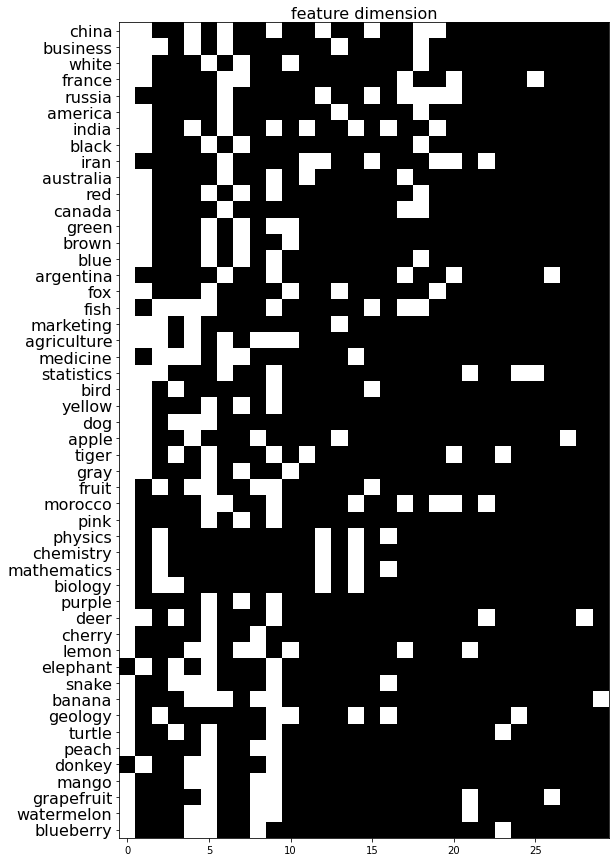

In [56]:
plt.figure(figsize=(10,15))
plt.yticks(np.arange(len(word_list)), word_list, fontsize = 16)
plt.xlabel('feature dimension', fontsize = 16)
plt.gca().xaxis.set_label_position('top')
plt.imshow(Z, cmap='gray')
plt.show()

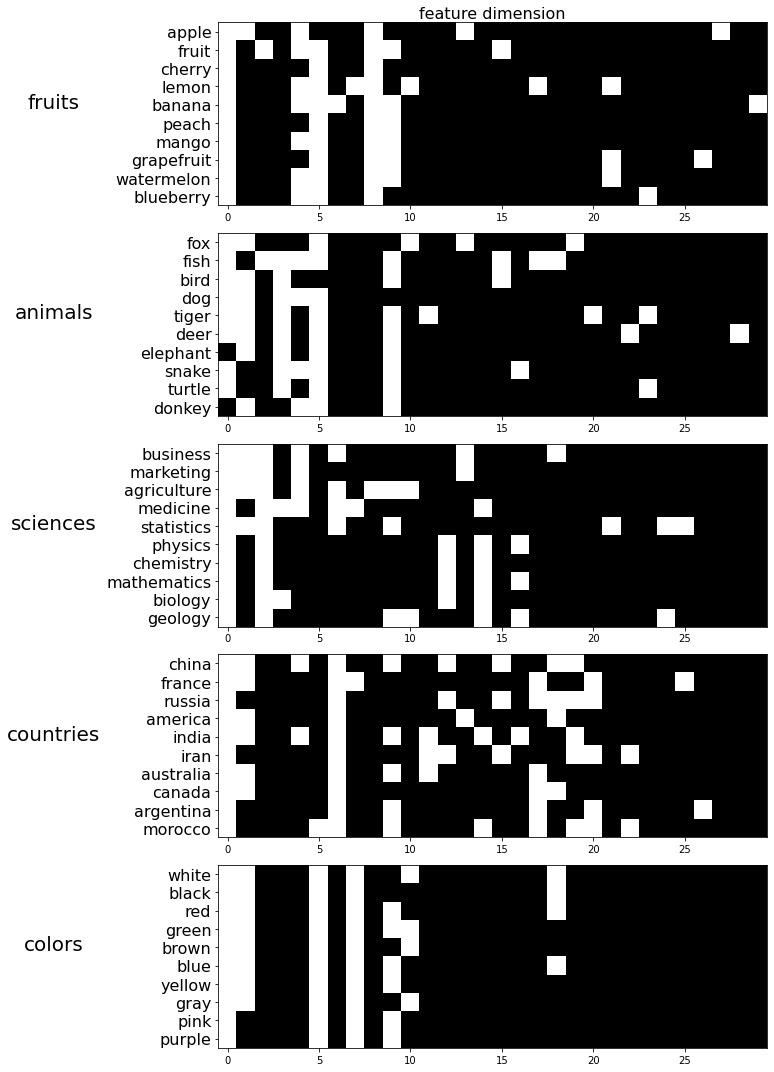

In [57]:
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,1+i)
    plt.imshow(Z[all_idx[i],:], cmap='gray')
    plt.yticks(np.arange(len(all_idx[i])), np.array(word_list)[all_idx[i]], fontsize = 16)
    if i == 0:
        plt.xlabel('feature dimension', fontsize = 16)
    plt.gca().xaxis.set_label_position('top')
    plt.title(categories[i], x=-0.3, y=0.5, fontsize = 20)
plt.tight_layout()
plt.show()

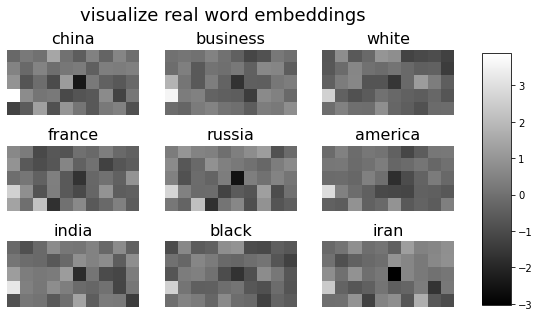

In [136]:
fig, axes = plt.subplots(3,3,figsize=(8,5))
fig.suptitle("visualize real word embeddings", fontsize=18)
for i,ax in enumerate(axes.flat[:9]):
    im = ax.imshow(X[i,:].reshape(5,10), cmap='gray', vmin = X.min(), vmax = X.max())
    ax.set_title(word_list[i], fontsize=16)    
    ax.axis('off')    
axes[-1,-1].axis('off')   
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

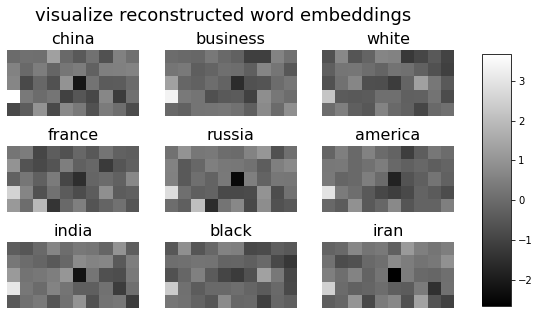

In [137]:
fig, axes = plt.subplots(3,3,figsize=(8,5))
fig.suptitle("visualize reconstructed word embeddings", fontsize=18)
for i,ax in enumerate(axes.flat[:9]):
    im = ax.imshow(X_prox[i,:].reshape(5,10), cmap='gray', vmin = X_prox.min(), vmax = X_prox.max())
    ax.set_title(word_list[i], fontsize=16)    
    ax.axis('off')    
axes[-1,-1].axis('off')   
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

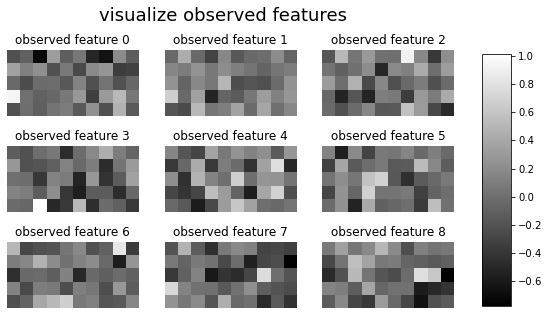

In [138]:
# show all learned features
fig, axes = plt.subplots(3,3,figsize=(8,5))
fig.suptitle("visualize observed features", fontsize=18)
for i,ax in enumerate(axes.flat[:A_prox.shape[0]]):
    im = ax.imshow(A_prox[i,:].reshape(5,10), cmap='gray', vmin = A_prox.min(), vmax = A_prox.max())
    ax.set_title('observed feature '+str(i))    
    ax.axis('off')    
axes[-1,-1].axis('off')   
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

In [149]:
figc.shape

(50,)

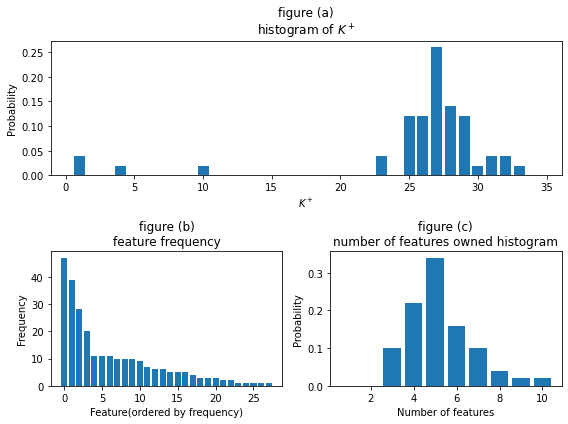

In [156]:
figa = history['K_plus'] #[100:]
figb = Z.sum(axis = 0)
figb.sort()
figc = Z.sum(axis = 1)
# figd = Z_groundtruth.sum(axis = 0)
# figd.sort()
# fige = Z_groundtruth.sum(axis = 1)


fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (8,6))
for ax in axs[0, 0:]:
    ax.remove()
gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, 0:])
axbig.hist(figa, bins = max(figa)+1, range=(0.5,max(figa)+1.5),rwidth = 0.8, density=True)
# axbig.set_xticks(np.arange(max(figa)+2))
axbig.set_xlabel('$K^+$')
axbig.set_ylabel('Probability')
axbig.set_title('figure (a)\nhistogram of $K^+$')


axs[1,0].bar(np.arange(figb.shape[0]), figb[::-1])
# axs[1,0].set_xticks(np.arange(8))
axs[1,0].set_xlabel('Feature(ordered by frequency)')
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_title('figure (b)\nfeature frequency')

axs[1,1].hist(figc, bins = int(figc.max()), range=(0.5,figc.max()+0.5) , rwidth = 0.8, density=True)
# axs[1,1].set_xticks(np.arange(8))
axs[1,1].set_xlabel('Number of features')
axs[1,1].set_ylabel('Probability')
axs[1,1].set_title('figure (c)\nnumber of features owned histogram')

# axs[2,0].bar(np.arange(4), figd[::-1])
# axs[2,0].set_xticks(np.arange(8))
# axs[2,0].set_xlabel('Feature(ordered by frequency)')
# axs[2,0].set_ylabel('Frequency')
# axs[2,0].set_ylim((0,figb.max()))
# axs[2,0].set_title('figure (d)')

# axs[2,1].hist(fige, bins = 4, range=(0.5,4.5) , rwidth = 0.8, density=True)
# axs[2,1].set_xticks(np.arange(8))
# axs[2,1].set_xlabel('Number of features')
# axs[2,1].set_ylabel('Probability')
# axs[2,1].set_title('figure (e)')

fig.tight_layout()
plt.show()

## spherized embeddings (not working)

https://projector.tensorflow.org/

In [35]:
centroid = embed.sum(axis = 0)
norms = np.linalg.norm(embed - centroid, axis = 1)
normed_embed = (embed - centroid)/norms[:,None]

In [38]:
X = normed_embed[idx,:]
X.shape

(50, 50)

In [51]:
history = infer(X, sigma_X = 0.1, num_iter = 2000, IBP_init = True, log_per_iter = 20)

iteration 0/2000: number of feature: 3


<ipython-input-43-0650fbbe8cbf>:4: RuntimeWarning: invalid value encountered in log
  - 1*(num_object - K_plus)*num_dim*np.log(sigma_X) \


iteration 20/2000: number of feature: 0
iteration 40/2000: number of feature: 0
iteration 60/2000: number of feature: 0
iteration 80/2000: number of feature: 0
iteration 100/2000: number of feature: 1
iteration 120/2000: number of feature: 0
iteration 140/2000: number of feature: 0
iteration 160/2000: number of feature: 0
iteration 180/2000: number of feature: 0
iteration 200/2000: number of feature: 0
iteration 220/2000: number of feature: 0
iteration 240/2000: number of feature: 0
iteration 260/2000: number of feature: 0
iteration 280/2000: number of feature: 0
iteration 300/2000: number of feature: 0
iteration 320/2000: number of feature: 0
iteration 340/2000: number of feature: 0
iteration 360/2000: number of feature: 0
iteration 380/2000: number of feature: 0
iteration 400/2000: number of feature: 0
iteration 420/2000: number of feature: 0
iteration 440/2000: number of feature: 0
iteration 460/2000: number of feature: 0
iteration 480/2000: number of feature: 0
iteration 500/2000: 

## semi-supervised

In [150]:
labels = np.zeros((X.shape[0], 5))
for i in range(5):
    for idx in all_idx[i]:
        labels[idx,i] = 1

In [68]:
history2 = infer(X, sigma_A = 1, sigma_X = 1, alpha = 1, num_iter = 1000, labels = labels, IBP_init = True, log_skip_iter = 100, log_per_iter = 20) 


iteration 0/1000: number of feature: 5
iteration 20/1000: number of feature: 5
iteration 40/1000: number of feature: 6
iteration 60/1000: number of feature: 14
iteration 80/1000: number of feature: 16
iteration 100/1000: number of feature: 19
iteration 120/1000: number of feature: 21
iteration 140/1000: number of feature: 22
iteration 160/1000: number of feature: 23
iteration 180/1000: number of feature: 26
iteration 200/1000: number of feature: 28
iteration 220/1000: number of feature: 27
iteration 240/1000: number of feature: 27
iteration 260/1000: number of feature: 27
iteration 280/1000: number of feature: 36
iteration 300/1000: number of feature: 29
iteration 320/1000: number of feature: 32
iteration 340/1000: number of feature: 34
iteration 360/1000: number of feature: 28
iteration 380/1000: number of feature: 29
iteration 400/1000: number of feature: 27
iteration 420/1000: number of feature: 27
iteration 440/1000: number of feature: 28
iteration 460/1000: number of feature: 30
i

In [349]:
Z = history2['Z'][-1]
sigma_X = history2['sigma_X'][-1]
sigma_A = history2['sigma_A'][-1]
K_plus = history2['K_plus'][-1]
M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
A_prox = M@Z.T@X
X_prox = Z@A_prox

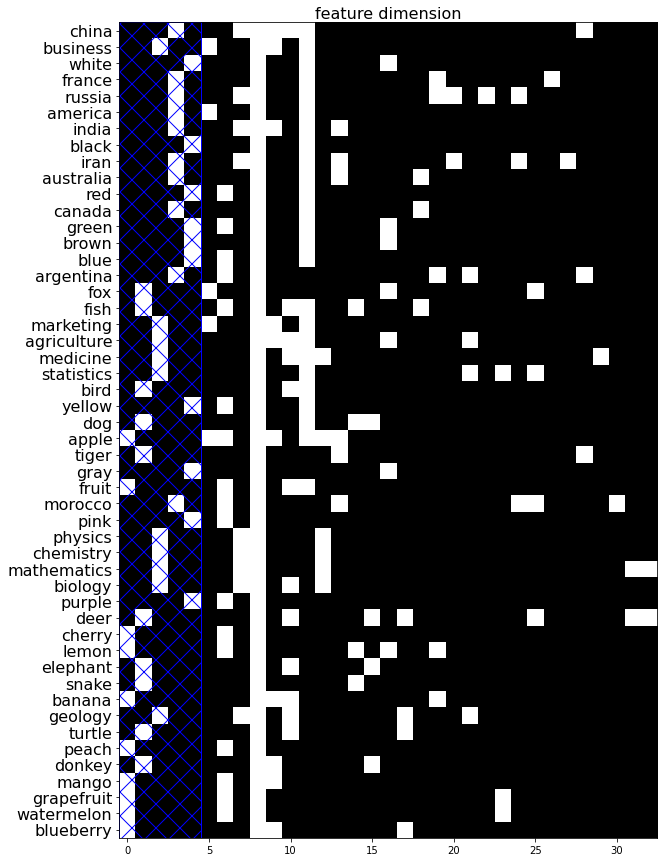

In [350]:
plt.figure(figsize=(10,15))
plt.yticks(np.arange(len(word_list)), word_list, fontsize = 16)
plt.xlabel('feature dimension', fontsize = 16)
plt.gca().xaxis.set_label_position('top')
plt.fill_between([-0.5,4.5],y1 = 49.5, y2=-0.5, color="none",hatch="X",edgecolor="b")
plt.imshow(Z, cmap='gray')
plt.xlim(-0.5,)
plt.ylim(49.5,-0.5)
plt.show()

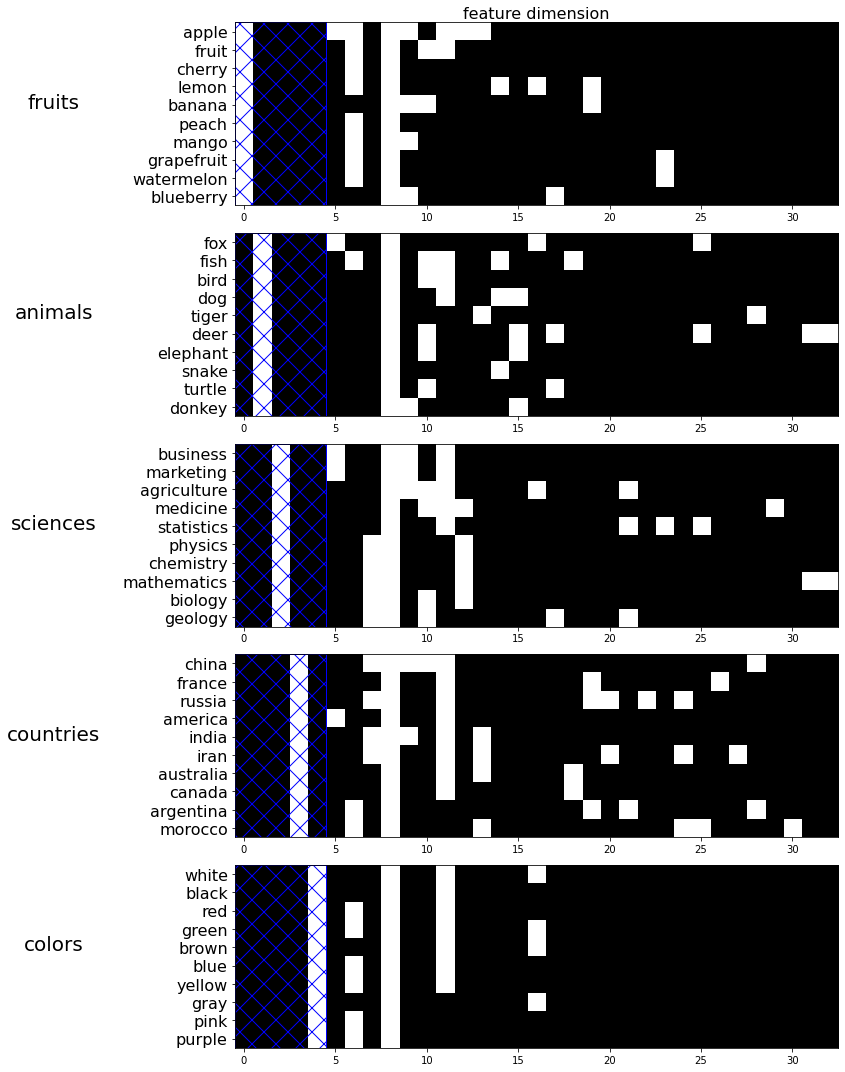

In [351]:
plt.figure(figsize=(10,15))
for i in range(5):
    plt.subplot(5,1,1+i)
    plt.imshow(Z[all_idx[i],:], cmap='gray')
    plt.yticks(np.arange(len(all_idx[i])), np.array(word_list)[all_idx[i]], fontsize = 16)
    plt.fill_between([-0.5,4.5],y1 = 9.5, y2=-0.5, color="none",hatch="X",edgecolor="b")
    if i == 0:
        plt.xlabel('feature dimension', fontsize = 16)
    plt.gca().xaxis.set_label_position('top')
    plt.title(categories[i], x=-0.3, y=0.5, fontsize = 20)
    plt.xlim(-0.5,)
    plt.ylim(9.5,-0.5)

plt.tight_layout()
plt.show()

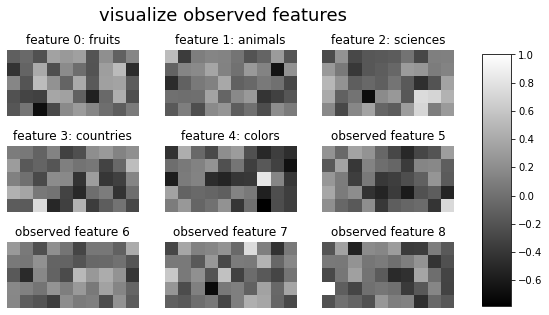

In [352]:
# show all learned features
fig, axes = plt.subplots(3,3,figsize=(8,5))
fig.suptitle("visualize observed features", fontsize=18)
for i,ax in enumerate(axes.flat[:A_prox.shape[0]]):
    im = ax.imshow(A_prox[i,:].reshape(5,10), cmap='gray', vmin = A_prox.min(), vmax = A_prox.max())
    if i < 5:
        ax.set_title('feature '+str(i) + ': '+ categories[i])    
    else:
        ax.set_title('observed feature '+str(i))    
    ax.axis('off')    
axes[-1,-1].axis('off')   
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

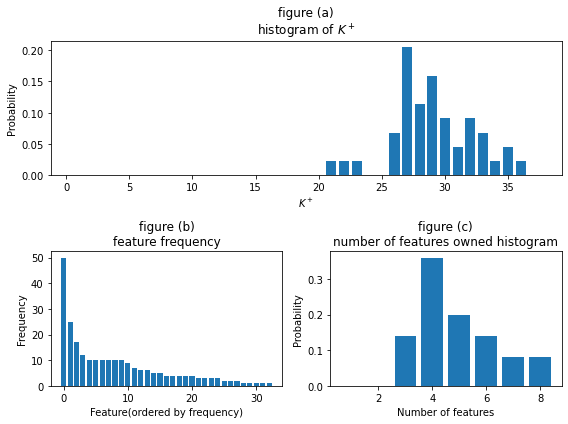

In [353]:
figa = history2['K_plus'] #[100:]
figb = Z.sum(axis = 0)
figb.sort()
figc = Z.sum(axis = 1)
# figd = Z_groundtruth.sum(axis = 0)
# figd.sort()
# fige = Z_groundtruth.sum(axis = 1)


fig, axs = plt.subplots(ncols=2, nrows=2, figsize = (8,6))
for ax in axs[0, 0:]:
    ax.remove()
gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, 0:])
axbig.hist(figa, bins = max(figa)+1, range=(0.5,max(figa)+1.5),rwidth = 0.8, density=True)
# axbig.set_xticks(np.arange(max(figa)+2))
axbig.set_xlabel('$K^+$')
axbig.set_ylabel('Probability')
axbig.set_title('figure (a)\nhistogram of $K^+$')


axs[1,0].bar(np.arange(figb.shape[0]), figb[::-1])
# axs[1,0].set_xticks(np.arange(8))
axs[1,0].set_xlabel('Feature(ordered by frequency)')
axs[1,0].set_ylabel('Frequency')
axs[1,0].set_title('figure (b)\nfeature frequency')

axs[1,1].hist(figc, bins = int(figc.max()), range=(0.5,figc.max()+0.5) , rwidth = 0.8, density=True)
# axs[1,1].set_xticks(np.arange(8))
axs[1,1].set_xlabel('Number of features')
axs[1,1].set_ylabel('Probability')
axs[1,1].set_title('figure (c)\nnumber of features owned histogram')

# axs[2,0].bar(np.arange(4), figd[::-1])
# axs[2,0].set_xticks(np.arange(8))
# axs[2,0].set_xlabel('Feature(ordered by frequency)')
# axs[2,0].set_ylabel('Frequency')
# axs[2,0].set_ylim((0,figb.max()))
# axs[2,0].set_title('figure (d)')

# axs[2,1].hist(fige, bins = 4, range=(0.5,4.5) , rwidth = 0.8, density=True)
# axs[2,1].set_xticks(np.arange(8))
# axs[2,1].set_xlabel('Number of features')
# axs[2,1].set_ylabel('Probability')
# axs[2,1].set_title('figure (e)')

fig.tight_layout()
plt.show()

In [354]:
def find_nearest_words(x, vocab, embed, n=10, metric = 'euclidean_distance'):
    if metric == 'euclidean_distance':
        score = np.linalg.norm(embed-x.reshape(1, -1), axis=1)
        top_n_idx = score.reshape(-1).argsort()[:n]
    else:
        score = sklearn.metrics.pairwise.cosine_similarity(embed, x.reshape(1, -1))
        top_n_idx = score.reshape(-1).argsort()[::-1][:n]
    words_and_distances = []
    for i in top_n_idx:
        words_and_distances.append((vocab[i], score[i]))
    return words_and_distances

In [206]:
# synthetic_word = A_prox[0,:] + A_prox[6,:] + A_prox[8,:]
synthetic_word = A_prox[11,:] + A_prox[19,:] + A_prox[8,:]

find_nearest_words(synthetic_word, vocab, embed, metric = 'euclidean_distance')

[('brought', 2.779299678469836),
 ('.', 2.8315192557236135),
 ('put', 2.8473206638889845),
 ('except', 2.8484799721233847),
 ('instance', 2.8552574061628047),
 ('exception', 2.8813931527898444),
 ('puts', 2.881457074172142),
 ('while', 2.883591854216092),
 ('bringing', 2.885944564173896),
 ('came', 2.8982502321415886)]

In [379]:
synthetic_word = A_prox[11,:] + A_prox[19,:] + A_prox[28,:]

df = pd.DataFrame()
nearest_words = find_nearest_words(synthetic_word, vocab, embed, metric = 'cosine_similarity')
column = []
for j,item in enumerate(nearest_words):
    column.append((item[0], str(item[1][0])[:7]))
df['similar words'] = column
display(df)


,similar words
0,"(france, 0.75064)"
1,"(advance, 0.74381)"
2,"(spain, 0.73485)"
3,"(against, 0.72825)"
4,"(ahead, 0.72601)"
5,"(us, 0.72429)"
6,"(losing, 0.72332)"
7,"(bid, 0.72098)"
8,"(russia, 0.72054)"
9,"(failed, 0.72002)"


In [172]:
find_nearest_words(X[2,:], vocab, embed, metric = 'euclidean_distance')

[('white', 0.0),
 ('black', 2.294861179495614),
 ('green', 2.5972569989059613),
 ('gray', 2.7076582627295784),
 ('brown', 2.721506490801556),
 ('blue', 3.15929894006012),
 ('red', 3.192774909565189),
 ('colored', 3.670290593168927),
 ('orange', 3.6931891207769203),
 ('bright', 3.7056535600158305)]

In [376]:
find_nearest_words(A_prox[0,:], vocab, embed, metric = 'euclidean_distance')

[('kd97', 2.029939777965842),
 ('str95bb', 2.0561955948550805),
 ('bb96', 2.058103899438513),
 ('js94bb', 2.058514481820138),
 ('k977-1', 2.0617378419366483),
 ('bdb94', 2.061892307481991),
 ('k978-1', 2.0639637056072084),
 ('str94', 2.0660063636863155),
 ('k587-1', 2.068130143996338),
 ('http://www.mediabynumbers.com', 2.0712279058644976)]

In [207]:
find_nearest_words(synthetic_word, vocab, embed, metric = 'cosine_similarity')

[('france', array([0.79425981])),
 ('french', array([0.7894253])),
 ('over', array([0.78536019])),
 ('with', array([0.78201492])),
 ('.', array([0.77107905])),
 ('for', array([0.76828905])),
 ('united', array([0.76752918])),
 ('put', array([0.76702571])),
 ('european', array([0.76669272])),
 ('while', array([0.76647867]))]

In [174]:
find_nearest_words(X[2,:], vocab, embed, metric = 'cosine_similarity')

[('white', array([1.])),
 ('black', array([0.90581369])),
 ('green', array([0.87377817])),
 ('gray', array([0.86134205])),
 ('brown', array([0.86090119])),
 ('blue', array([0.8225342])),
 ('red', array([0.81493637])),
 ('colored', array([0.74938195])),
 ('orange', array([0.74255839])),
 ('bright', array([0.73476275]))]

In [375]:
df = pd.DataFrame()

for i in range(10):
    nearest_words = find_nearest_words(A_prox[i,:], vocab, embed, metric = 'cosine_similarity')
    column = []
    for j,item in enumerate(nearest_words):
        column.append((item[0], str(item[1][0])[:7]))
    df['feature '+str(i)] = column
display(df)


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9
0,"(cherries, 0.79268)","(shark, 0.72670)","(mathematics, 0.78229)","(portugal, 0.70282)","(wore, 0.83015)","(aol, 0.77922)","(lime, 0.69261)","(physics, 0.74692)","(black, 0.86610)","(worldvision, 0.64605)"
1,"(blueberry, 0.78979)","(dolphin, 0.67857)","(chemistry, 0.76648)","(netherlands, 0.69495)","(pink, 0.82092)","(viacom, 0.69973)","(bunches, 0.69258)","(mathematics, 0.69336)","(blue, 0.80446)","(laloo, 0.63215)"
2,"(peach, 0.77522)","(elephant, 0.67403)","(sociology, 0.75598)","(bulgaria, 0.67584)","(purple, 0.82068)","(warner, 0.69868)","(apricot, 0.68301)","(theoretical, 0.65086)","(green, 0.80399)","(bsnl, 0.62451)"
3,"(almond, 0.77033)","(scaredy, 0.66193)","(psychology, 0.75290)","(republic, 0.67244)","(gray, 0.81780)","(comcast, 0.69388)","(piccolos, 0.68165)","(mineralogy, 0.64853)","(red, 0.80384)","(palmoil, 0.62342)"
4,"(cobbler, 0.76049)","(cat, 0.65372)","(analytical, 0.72865)","(spain, 0.67100)","(jacket, 0.80609)","(llc, 0.68622)","(chilies, 0.66921)","(chemistry, 0.64729)","(golden, 0.78299)","(yuel, 0.61903)"
5,"(pomegranate, 0.74859)","(rabbit, 0.64774)","(engineering, 0.72666)","(greece, 0.66270)","(blue, 0.80426)","(disney, 0.67679)","(karsums, 0.66400)","(nanoscale, 0.63988)","(white, 0.77180)","(parastatal, 0.61809)"
6,"(candied, 0.74782)","(whale, 0.64040)","(anthropology, 0.72584)","(malta, 0.65829)","(black, 0.78911)","(corporate, 0.67619)","(chilis, 0.65552)","(waseda, 0.63318)","(pink, 0.76406)","(karamjit, 0.61615)"
7,"(rhubarb, 0.74648)","(crocodile, 0.63930)","(theoretical, 0.72567)","(morocco, 0.65716)","(stripes, 0.78854)","(yahoo, 0.67110)","(jicama, 0.65392)","(pedagogical, 0.62615)","(purple, 0.76310)","(displayport, 0.61212)"
8,"(pickle, 0.74236)","(dingo, 0.63873)","(economics, 0.71850)","(cuba, 0.65603)","(wearing, 0.78426)","(entertainment, 0.66188)","(numancia, 0.64960)","(astroparticle, 0.61918)","(dark, 0.74809)","(bharti, 0.60909)"
9,"(sorbet, 0.73917)","(frog, 0.63859)","(biochemistry, 0.71813)","(romania, 0.65286)","(maroon, 0.78258)","(compuserve, 0.65368)","(grapefruit, 0.64783)","(mathematical, 0.60269)","(orange, 0.74175)","(campero, 0.60357)"


In [372]:
for i in range(10):
    df = pd.DataFrame(columns = ['word', 'cosine_similarity'])
    nearest_words = find_nearest_words(A_prox[i,:], vocab, embed, metric = 'cosine_similarity')
    for j,item in enumerate(nearest_words):
        df.loc[j]=[item[0], item[1][0]]
#     df.style.set_table_attributes("style='display:inline'").set_caption('category:'+categories[i])
    display(df)


,word,cosine_similarity
0,cherries,0.792688
1,blueberry,0.789791
2,peach,0.775229
3,almond,0.770335
4,cobbler,0.760491
5,pomegranate,0.748592
6,candied,0.747829
7,rhubarb,0.746485
8,pickle,0.742367
9,sorbet,0.739171


,word,cosine_similarity
0,shark,0.726708
1,dolphin,0.678575
2,elephant,0.674034
3,scaredy,0.661933
4,cat,0.653726
5,rabbit,0.647747
6,whale,0.640410
7,crocodile,0.639300
8,dingo,0.638731
9,frog,0.638596


,word,cosine_similarity
0,mathematics,0.782294
1,chemistry,0.766485
2,sociology,0.755986
3,psychology,0.752907
4,analytical,0.728657
5,engineering,0.726660
6,anthropology,0.725846
7,theoretical,0.725672
8,economics,0.718505
9,biochemistry,0.718131


,word,cosine_similarity
0,portugal,0.702828
1,netherlands,0.694956
2,bulgaria,0.675844
3,republic,0.672442
4,spain,0.671008
5,greece,0.662710
6,malta,0.658295
7,morocco,0.657168
8,cuba,0.656036
9,romania,0.652864


,word,cosine_similarity
0,wore,0.830151
1,pink,0.820923
2,purple,0.820680
3,gray,0.817804
4,jacket,0.806092
5,blue,0.804268
6,black,0.789114
7,stripes,0.788547
8,wearing,0.784260
9,maroon,0.782584


,word,cosine_similarity
0,aol,0.779229
1,viacom,0.699730
2,warner,0.698688
3,comcast,0.693889
4,llc,0.686221
5,disney,0.676793
6,corporate,0.676199
7,yahoo,0.671100
8,entertainment,0.661890
9,compuserve,0.653686


,word,cosine_similarity
0,lime,0.692610
1,bunches,0.692581
2,apricot,0.683019
3,piccolos,0.681650
4,chilies,0.669212
5,karsums,0.664006
6,chilis,0.655529
7,jicama,0.653922
8,numancia,0.649608
9,grapefruit,0.647835


,word,cosine_similarity
0,physics,0.746922
1,mathematics,0.693368
2,theoretical,0.650868
3,mineralogy,0.648530
4,chemistry,0.647292
5,nanoscale,0.639887
6,waseda,0.633186
7,pedagogical,0.626152
8,astroparticle,0.619189
9,mathematical,0.602697


,word,cosine_similarity
0,black,0.866103
1,blue,0.804463
2,green,0.803995
3,red,0.803843
4,golden,0.782996
5,white,0.771805
6,pink,0.764064
7,purple,0.763105
8,dark,0.748099
9,orange,0.741759


,word,cosine_similarity
0,worldvision,0.646054
1,laloo,0.632156
2,bsnl,0.624517
3,palmoil,0.623427
4,yuel,0.619032
5,parastatal,0.618093
6,karamjit,0.616150
7,displayport,0.612128
8,bharti,0.609091
9,campero,0.603576


In [205]:
find_nearest_words(A_prox[0,:], vocab, embed, metric = 'cosine_similarity')

[('cherries', array([0.79268757])),
 ('blueberry', array([0.78979141])),
 ('peach', array([0.77522946])),
 ('almond', array([0.77033542])),
 ('cobbler', array([0.76049081])),
 ('pomegranate', array([0.74859236])),
 ('candied', array([0.74782884])),
 ('rhubarb', array([0.74648482])),
 ('pickle', array([0.74236698])),
 ('sorbet', array([0.73917112]))]

In [187]:
centroid = embed.sum(axis = 0)
norms = np.linalg.norm(embed - centroid, axis = 1)
normed_embed = (embed - centroid)/norms[:,None]

norm = np.linalg.norm(A_prox[2,:] - centroid)
normed_x = (A_prox[2,:] - centroid)/norm

In [188]:
norm = np.linalg.norm(X[2,:] - centroid)
normed_x = (X[2,:] - centroid)/norm

In [189]:
find_nearest_words(normed_x, vocab, normed_embed, metric = 'cosine_similarity')

[('white', array([1.])),
 ('black', array([1.])),
 ('gray', array([1.])),
 ('green', array([1.])),
 ('straightener', array([1.])),
 ('brown', array([1.])),
 ('light-colored', array([1.])),
 ('blood-red', array([1.])),
 ('stinkwood', array([1.])),
 ('ecru', array([1.]))]

In [190]:
find_nearest_words(normed_x, vocab, normed_embed, metric = 'euclidean_distance')

[('white', 2.140912511205415e-16),
 ('black', 4.082475509844446e-06),
 ('gray', 4.420460065713855e-06),
 ('green', 4.496105397021316e-06),
 ('straightener', 4.798953252011358e-06),
 ('brown', 4.80397938694234e-06),
 ('light-colored', 4.818306789170287e-06),
 ('blood-red', 4.863696364292146e-06),
 ('stinkwood', 4.869211300223045e-06),
 ('ecru', 4.882550061239889e-06)]

In [200]:
X[fruit_idx].mean(axis = 0)/np.linalg.norm(X[fruit_idx].mean(axis = 0))


array([ 0.00533641, -0.01787854, -0.19873847,  0.22222647,  0.09749482,
        0.11854932, -0.13237801, -0.05128171,  0.02827775,  0.07647994,
       -0.09463979,  0.01749037,  0.24813689, -0.07811896,  0.05922052,
       -0.0262983 , -0.07145906,  0.13986933,  0.11535557, -0.21720439,
       -0.02110517, -0.18968447,  0.25563991,  0.04325991, -0.09342878,
        0.05797962, -0.05496449,  0.23259176,  0.17238111, -0.16514826,
        0.30592708, -0.0583743 , -0.14054475,  0.24027601,  0.07937818,
        0.03047899, -0.25740228,  0.055982  ,  0.16992432, -0.16753858,
       -0.06745765, -0.00736106, -0.2194927 , -0.16200851,  0.18280955,
        0.14738331,  0.04645289, -0.13066189,  0.03813754, -0.03698073])

In [201]:
A_prox[0,:]/np.linalg.norm(A_prox[0,:])

array([-0.05726719, -0.01751745, -0.10456211,  0.16901264,  0.13980601,
        0.16234777, -0.09291117,  0.10483205, -0.04888838,  0.07517027,
       -0.20622353, -0.03880031,  0.19558154, -0.11026077,  0.09321433,
       -0.0073865 , -0.0976044 ,  0.15647898,  0.25486614, -0.2285901 ,
        0.07693528, -0.09432162,  0.25718746,  0.11497884, -0.03950574,
        0.19650431, -0.07798253,  0.16215425,  0.17664075, -0.06806152,
       -0.10072558, -0.14833133, -0.1561608 ,  0.18323812,  0.16692315,
       -0.04872101, -0.26982613, -0.01802127,  0.2107482 , -0.11272128,
       -0.08700075,  0.01866338, -0.33146007, -0.12923918,  0.08929448,
        0.14798069,  0.07660203, -0.00626841, -0.06324882,  0.03886811])

In [204]:
result = 1 - spatial.distance.cosine(X[fruit_idx].mean(axis = 0), A_prox[0,:])
result

0.7946981943693108

In [208]:
find_nearest_words(X[fruit_idx].mean(axis = 0), vocab, embed, metric = 'cosine_similarity')

[('mango', array([0.930017])),
 ('peach', array([0.90159437])),
 ('pineapple', array([0.89876458])),
 ('fruit', array([0.8744893])),
 ('pear', array([0.86853496])),
 ('tomato', array([0.86257965])),
 ('juice', array([0.86092226])),
 ('coconut', array([0.85340767])),
 ('plum', array([0.84996229])),
 ('apricot', array([0.8445478]))]

In [209]:
find_nearest_words(X[fruit_idx].mean(axis = 0), vocab, embed, metric = 'euclidean_distance')

[('mango', 1.8203236106026537),
 ('peach', 2.0437119116986633),
 ('plum', 2.335863235674106),
 ('pineapple', 2.352487001535914),
 ('cherry', 2.4499484179834248),
 ('pear', 2.452042962546458),
 ('bean', 2.4811914977718237),
 ('pomegranate', 2.565040562030597),
 ('pumpkin', 2.6212278468048122),
 ('watermelon', 2.627281535041358)]

## average of moving windows

https://www.kaggle.com/rmisra/news-category-dataset

In [224]:
df = pd.read_json('dataset/News_Category_Dataset_v2.json', lines=True)
df

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [232]:
df.groupby("category").count()

,headline,authors,link,short_description,date
category,,,,,
ARTS,1509,1509,1509,1509,1509
ARTS & CULTURE,1339,1339,1339,1339,1339
BLACK VOICES,4528,4528,4528,4528,4528
BUSINESS,5937,5937,5937,5937,5937
COLLEGE,1144,1144,1144,1144,1144
COMEDY,5175,5175,5175,5175,5175
CRIME,3405,3405,3405,3405,3405
CULTURE & ARTS,1030,1030,1030,1030,1030
DIVORCE,3426,3426,3426,3426,3426


In [333]:
df.iloc[11]

category                                                    WORLD NEWS
headline             South Korean President Meets North Korea's Kim...
authors                                                               
link                 https://www.huffingtonpost.com/entry/south-kor...
short_description    The two met to pave the way for a summit betwe...
date                                               2018-05-26 00:00:00
Name: 11, dtype: object

In [341]:
doc_idx_list = [11, 122, 145]
docs = []
doc_slices = []
doc_slices_labels = []
window_size = 3    # n words before and n words after
step = 1
for idx in doc_idx_list:
    doc = word_tokenize(df.iloc[idx]['short_description'].lower())
    for word in doc:
        if word not in vocab:
            print(word+' not existing in vocab')
            doc.remove(word)
    docs.append(doc)
            
    for i in range(window_size,len(doc)-window_size, step):
        doc_slices.append(doc[i-window_size:i+window_size+1])
        doc_slices_labels.append(idx)

In [342]:
for i in docs:
    print(' '.join(i))

the two met to pave the way for a summit between north korean and the u.s .
“ why did you shoot at the girl ? you killed her ! ” a bystander asks in viral video that shows the aftermath of the shooting .
`` he ’ s my brother , so it ’ s hard . i may not have a very clear perspective on it , but i ’ m trying to . ”


In [343]:
len(doc_slices)

59

In [344]:
word_embed_avgs = np.zeros((len(doc_slices), 50))
for i,doc_slice in enumerate(doc_slices):
    for word in doc_slice:
        word_idx = vocab.index(word)
        word_embed_avgs[i,:] += embed[word_idx,:]
word_embed_avgs = word_embed_avgs/5

In [345]:
history3 = infer(word_embed_avgs, num_iter = 2000, IBP_init = False, log_per_iter = 50)

iteration 0/2000: number of feature: 1
iteration 50/2000: number of feature: 1
iteration 100/2000: number of feature: 3
iteration 150/2000: number of feature: 3
iteration 200/2000: number of feature: 3
iteration 250/2000: number of feature: 3
iteration 300/2000: number of feature: 3
iteration 350/2000: number of feature: 3
iteration 400/2000: number of feature: 3
iteration 450/2000: number of feature: 3
iteration 500/2000: number of feature: 3
iteration 550/2000: number of feature: 3
iteration 600/2000: number of feature: 3
iteration 650/2000: number of feature: 3
iteration 700/2000: number of feature: 3
iteration 750/2000: number of feature: 3
iteration 800/2000: number of feature: 3
iteration 850/2000: number of feature: 3
iteration 900/2000: number of feature: 3
iteration 950/2000: number of feature: 3
iteration 1000/2000: number of feature: 3
iteration 1050/2000: number of feature: 3
iteration 1100/2000: number of feature: 3
iteration 1150/2000: number of feature: 3
iteration 1200/

In [346]:
Z = history3['Z'][-1]
sigma_X = history3['sigma_X'][-1]
sigma_A = history3['sigma_A'][-1]
K_plus = history3['K_plus'][-1]
M = np.linalg.inv(Z.T@Z + (sigma_X**2/sigma_A**2)*np.diag(np.ones(K_plus)))
A_prox = M@Z.T@word_embed_avgs
X_prox = Z@A_prox

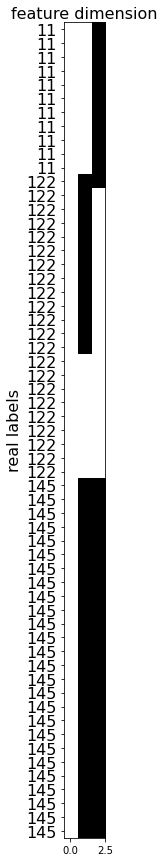

In [347]:
plt.figure(figsize=(10,15))
plt.yticks(np.arange(len(doc_slices_labels)), doc_slices_labels, fontsize = 16)
plt.xlabel('feature dimension', fontsize = 16)
plt.ylabel('real labels', fontsize = 16)

plt.gca().xaxis.set_label_position('top')
# plt.fill_between([-0.5,4.5],y1 = 49.5, y2=-0.5, color="none",hatch="X",edgecolor="b")
plt.imshow(Z, cmap='gray')
# plt.xlim(-0.5,)
# plt.ylim(49.5,-0.5)
plt.show()